In [26]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import os
import pathlib
import tensorflow_addons as tfa
from tensorflow.python.client import device_lib

In [27]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  4


In [28]:
physical_devices = tf.config.list_physical_devices('GPU')

In [29]:
tf.config.set_visible_devices(
    physical_devices[1], 'GPU'
)

# Data Loading

In [30]:
path_train = 'CINIC10/train/'
path_valid = 'CINIC10/valid/'
path_test = 'CINIC10/test/'
data_dir_train = pathlib.Path(path_train)
data_dir_val = pathlib.Path(path_valid)
data_dir_test = pathlib.Path(path_test)

In [31]:
list_ds_train = tf.data.Dataset.list_files(str(data_dir_train/'*/*'))
list_ds_val = tf.data.Dataset.list_files(str(data_dir_val/'*/*'))
list_ds_test = tf.data.Dataset.list_files(str(data_dir_test/'*/*'))

In [32]:
CLASS_NAMES = np.array([item.name for item in data_dir_train.glob('*')])

In [33]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == CLASS_NAMES

In [34]:
def decode_img(img,dsize):
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [dsize[0], dsize[1]])

In [35]:
def process_path(file_path):
    size = (299,299)
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img,size )
    return img, label

In [36]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [37]:
labeled_ds_train = list_ds_train.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_ds_valid = list_ds_val.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_ds_test = list_ds_test.map(process_path, num_parallel_calls=AUTOTUNE)

In [38]:
def normalize(x, y):
    x = tf.image.per_image_standardization(x)
    return x, y

In [39]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000, batch_size = 128):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.map(normalize)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [40]:
train_ds = prepare_for_training(labeled_ds_train, batch_size = 8)
val_ds = prepare_for_training(labeled_ds_valid, batch_size = 8)
test_ds = prepare_for_training(labeled_ds_test, batch_size = 8)

# Xception Details

Optimization Configuration used for ImageNet:
* Optimizer: RMSprop/SGD
* Momentum: 0.9
* Initial learning rate: 0.045
* Learning rate decay: decay of rate 0.94 every 2 epochs

Regularization:
* Weight decay: 1e-5
* No dropout
* No auxilairy loss


# Model Definition

In [41]:
class Model:
    def __init__(self, n_classes):
        self.n_classes = n_classes
        
    def initial_block(self,inputs):
        x = tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding='same')(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.nn.relu(x)
        
        x = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.nn.relu(x)
        return x
 
    def reg_block(self,x, n_channels_c1, n_channels_c2, pre_activation = True):
        res = tf.keras.layers.Conv2D(n_channels_c2, kernel_size=1,strides=2, padding='same')(x)
        res = tf.keras.layers.BatchNormalization()(res)
        if pre_activation:
            x = tf.nn.relu(x)
        
        x = tf.keras.layers.SeparableConv2D(n_channels_c1, kernel_size=3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x) 
        x = tf.nn.relu(x)
        
        x = tf.keras.layers.SeparableConvolution2D(n_channels_c2, kernel_size= 3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
        x = tf.keras.layers.Add()([res, x])
        return x
    
    def final_block(self,x):
        x = tf.keras.layers.SeparableConv2D(1536, kernel_size=3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.nn.relu(x)
        x = tf.keras.layers.SeparableConv2D(2048, kernel_size=3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.nn.relu(x)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(500, activation='relu')(x)
        x = tf.keras.layers.Dense(self.n_classes, activation='softmax')(x)
        return x
        
    def entry_flow(self,inputs):
        x = self.initial_block(inputs)
        x = self.reg_block(x, 128, 128, pre_activation=False)
        x = self.reg_block(x, 256, 256)
        x = self.reg_block(x, 728, 728)
        return x
    
    def middle_flow(self,x):
        for i in range(8):
            initial_state = x
            x = tf.nn.relu(x)
            x = tf.keras.layers.SeparableConv2D(728,kernel_size=3,padding='same')(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.nn.relu(x)
            x = tf.keras.layers.SeparableConv2D(728,kernel_size=3,padding='same')(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.nn.relu(x)
            x = tf.keras.layers.SeparableConv2D(728,kernel_size=3,padding='same')(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Add()([x, initial_state])
        return x
    
    def exit_flow(self,x):
        x = self.reg_block(x, 728,1024)
        x = self.final_block(x)
        return x
        
    def build_model(self):
        inputs = tf.keras.layers.Input(shape=(299,299,3))
        x = self.entry_flow(inputs)
        x = self.middle_flow(x)
        x = self.exit_flow(x)
        model = tf.keras.Model(inputs, x)
        return model

In [42]:
model_ = Model(10)

In [43]:
model = model_.build_model()

In [44]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 150, 150, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 150, 150, 32) 128         conv2d_6[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_Relu_35 (TensorFlow [(None, 150, 150, 32 0           batch_normalization_40[0][0]     
____________________________________________________________________________________________

# Training

In [45]:
def step_decay(epoch):
    initial_lrate = 0.045
    drop = 0.94
    epochs_drop = 2
    lrate = initial_lrate * tf.math.pow(drop,tf.math.floor((1+epoch)/epochs_drop))
    return lrate

In [46]:
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

In [47]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))

In [48]:
loss_history = LossHistory()
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)
callbacks_list = [loss_history, lrate]

In [49]:
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.9 ),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [50]:
history = model.fit(train_ds,
                   epochs = 74,
                   #callbacks=callbacks_list,
                   steps_per_epoch = 100,
                   verbose = 1,
                   validation_data = val_ds,
                   validation_steps = 100)

Train for 100 steps, validate for 100 steps
Epoch 1/74
100/100 [==============================] - 27s 266ms/step - loss: 2.2011 - accuracy: 0.1713 - val_loss: 2.3033 - val_accuracy: 0.0938
Epoch 2/74
100/100 [==============================] - 22s 217ms/step - loss: 2.1122 - accuracy: 0.2163 - val_loss: 2.3049 - val_accuracy: 0.0862
Epoch 3/74
100/100 [==============================] - 22s 219ms/step - loss: 2.0829 - accuracy: 0.2100 - val_loss: 2.3008 - val_accuracy: 0.1163
Epoch 4/74
100/100 [==============================] - 22s 225ms/step - loss: 2.0085 - accuracy: 0.2663 - val_loss: 2.3004 - val_accuracy: 0.1075
Epoch 5/74
100/100 [==============================] - 22s 222ms/step - loss: 1.9813 - accuracy: 0.2400 - val_loss: 2.2776 - val_accuracy: 0.1488
Epoch 6/74
100/100 [==============================] - 23s 231ms/step - loss: 1.9950 - accuracy: 0.2562 - val_loss: 2.2184 - val_accuracy: 0.1875
Epoch 7/74
100/100 [==============================] - 22s 222ms/step - loss: 1.9532 - 

# Evaluation

In [53]:
loss_test, accuracy_test = model.evaluate(test_ds,
                                         verbose = 1,
                                         steps=5)

5/5 [==============================] - 10s 2s/step - loss: 1.3924 - accuracy: 0.4750


In [54]:
loss_test, accuracy_test

(1.392409873008728, 0.475)

# Training results visualization

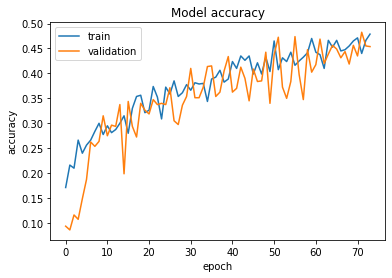

In [55]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

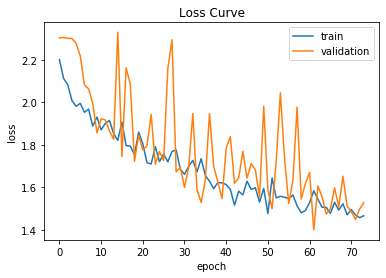

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()